In [113]:
########################################
#             PATH SETUP
########################################

import sys
import os
sys.path.insert(0, os.path.abspath("."))

########################################
#             LIBRERIES SETUP
########################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
import math, re
########################################
#             SIMULATION LIBRARIES
########################################
from lemer.rngs import MultiStreamRNG
from lemer.rvms import *
from typing import List, Optional, Tuple
from simulator.simulation import Simulation

In [130]:
#Utils
_TCRIT_95 = {
    1: 12.706, 2: 4.303, 3: 3.182, 4: 2.776, 5: 2.571, 6: 2.447, 7: 2.365, 8: 2.306, 9: 2.262,
    10: 2.228, 11: 2.201, 12: 2.179, 13: 2.160, 14: 2.145, 15: 2.131, 16: 2.120, 17: 2.110,
    18: 2.101, 19: 2.093, 20: 2.086, 21: 2.080, 22: 2.074, 23: 2.069, 24: 2.064, 25: 2.060,
    26: 2.056, 27: 2.052, 28: 2.048, 29: 2.045, 30: 2.042
}
def _tcrit(df: int) -> float:
    return _TCRIT_95.get(df, 1.96) if df > 0 else float("nan")

# --- aggregatore generico mean ± CI95% per metrica y raggruppata per x ---
def agg_ci(df: pd.DataFrame, x: str, y: str) -> pd.DataFrame:
    # NOTE: usa _tcrit(...) già definita UNA VOLTA nel tuo blocco utils
    g = df.groupby(x)[y].agg(["mean", "std", "count"]).reset_index()
    n = g["count"].to_numpy(dtype=float)
    t = np.where(n > 30, 1.96, np.array([_tcrit(int(max(1, k-1))) for k in n]))
    sem = g["std"].fillna(0.0).to_numpy() / np.sqrt(np.maximum(n, 1.0))
    ci = t * sem
    g["ci_lo"] = g["mean"] - ci
    g["ci_hi"] = g["mean"] + ci
    g["n"] = n
    return g.sort_values(x).reset_index(drop=True)



def mean_ci(series: pd.Series) -> Tuple[float, float, float, int]:
    x = pd.to_numeric(series, errors="coerce").dropna().values
    n = len(x)
    if n == 0: return np.nan, np.nan, np.nan, 0
    m = float(np.mean(x))
    if n == 1: return m, np.nan, np.nan, 1
    s = float(np.std(x, ddof=1))
    half = _tcrit(n-1) * s / math.sqrt(n)
    return m, m-half, m+half, n



def _node_order(scopes: list[str]) -> list[str]:
    """Ordina alfabeticamente i NODE_* (A,B,C,...) per avere pannelli stabili."""
    nodes = [s for s in scopes if isinstance(s, str) and s.startswith("NODE_")]
    return sorted(nodes, key=lambda s: s.replace("NODE_", ""))


def _node_label(scope: str) -> str:
    """Etichetta leggibile per un NODE_*."""
    name = scope.replace("NODE_", "")
    mapping = {"A":"Server A", "B":"Server B", "C":"Server C", "P":"Server P"}
    return mapping.get(name, f"Server {name}")


plt.rcParams.update({
    "figure.figsize": (7.4, 5.0),
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.35,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titlelocation": "left",
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "legend.frameon": False,
    "lines.linewidth": 1.8,
    "lines.markersize": 5.5,
})
PALETTE = {
    "THEORY": "#1f77b4",   # blu per teoria
    "SIM":    "#ff7f0e",   # arancio per simulazione
    "A":      "#2ca02c",   # verde
    "B":      "#d62728",   # rosso
    "C":      "#000000",   # rosso
    "P":      "#9467bd",   # viola
}



BASE_DIR = ".output_simulation"

# configurazione all'inizio del notebook
OBJ = 3   # scegli 1, 2 o 3

# costruisco dinamicamente il nome del file
config_file = f"obj{OBJ}_lb.json"
TITLE_PREFIX = f"OBJ{OBJ}"



In [131]:
# ================== Loader + Plotting "alla Torkin" (versione migliorata) ==================

import os, re, glob, math
from pathlib import Path
from typing import List, Optional, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- stile matplotlib sobrio ----------


# ================== DISCOVERY / LOAD ==================

def find_csv_for_config(config_path: str, base_dir=BASE_DIR) -> List[str]:
    cfg_name = Path(config_path).stem
    pattern  = os.path.join(base_dir, f"results_{cfg_name}*.csv")
    return sorted(glob.glob(pattern))

def _parse_lambda_from_filename(fname: str) -> Optional[float]:
    base = Path(fname).stem.lower()
    m = re.search(r"(?:lam|lambda|gamma|load)[=_]?([0-9]+(?:\.[0-9]+)?)", base)
    if m: return float(m.group(1))
    # fallback prudente
    for tok in re.findall(r"([0-9]+\.[0-9]+)", base):
        val = float(tok)
        if 0.1 <= val <= 5.0:
            return val
    return None

def load_runs(csv_files: List[str]) -> pd.DataFrame:
    dfs = []
    for i, f in enumerate(csv_files):
        df = pd.read_csv(f)
        df["source"]  = os.path.basename(f)
        df["replica"] = i
        if "arrival_rate" not in df.columns:
            df["arrival_rate"] = _parse_lambda_from_filename(f)
        dfs.append(df)
    if not dfs:
        raise FileNotFoundError("Nessun CSV.")
    df = pd.concat(dfs, ignore_index=True)

    if "mean_response_time" not in df.columns:
        for alt in ("response_time_mean", "rt_mean"):
            if alt in df.columns:
                df = df.rename(columns={alt: "mean_response_time"})
                break
    return df


# ================== STATISTICA (CI t-based 95%) ==================




# ================== SCELTA X ==================

def choose_overall_x(df_overall: pd.DataFrame) -> Tuple[str, str]:
    """arrival_rate -> throughput -> replica"""
    if "arrival_rate" in df_overall.columns and df_overall["arrival_rate"].notna().sum() >= 2:
        return "arrival_rate", "Arrival Rate (λ)"
    if "throughput" in df_overall.columns and df_overall["throughput"].nunique() >= 2:
        return "throughput", "Throughput (req/s)"
    return "replica", "Replica"

def choose_node_x(df_nodes: pd.DataFrame) -> Tuple[str, str]:
    if "arrival_rate" in df_nodes.columns and df_nodes["arrival_rate"].notna().sum() >= 2:
        return "arrival_rate", "Arrival Rate (λ)"
    if "utilization" in df_nodes.columns and df_nodes["utilization"].nunique() >= 2:
        return "utilization", "Utilization ρ"
    if "throughput" in df_nodes.columns and df_nodes["throughput"].nunique() >= 2:
        return "throughput", "Throughput (req/s)"
    return "replica", "Replica"

# ================== PLOTTING (Torkin-like) ==================

def _axes_clean(ax, xlabel, ylabel, title):
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, which="both", linestyle="--", alpha=0.35)

def line_with_ci(df: pd.DataFrame, x: str, y: str, title: str, xlabel: str, ylabel: str):
    """Linea + banda CI 95% (fill_between)"""
    rows = []
    for xv, g in df.groupby(x):
        m, lo, hi, n = mean_ci(g[y])
        rows.append((xv, m, lo, hi, n))
    g = pd.DataFrame(rows, columns=[x, "mean", "ci_lo", "ci_hi", "n"]).sort_values(x)

    fig, ax = plt.subplots()
    ax.plot(g[x], g["mean"], marker="o")
    # banda CI
    ylo = g["ci_lo"].to_numpy(dtype=float)
    yhi = g["ci_hi"].to_numpy(dtype=float)
    ylo = np.where(np.isfinite(ylo), ylo, g["mean"])
    yhi = np.where(np.isfinite(yhi), yhi, g["mean"])
    ax.fill_between(g[x], ylo, yhi, alpha=0.18, linewidth=0)

    _axes_clean(ax, xlabel, ylabel, title)
    plt.show()

def nodes_small_multiples(df_nodes: pd.DataFrame, x: str, y: str,
                          xlabel: str, ylabel: str, suptitle: str | None = None):
    """
    Small-multiples dinamico: un subplot per ogni NODE_* presente.
    Mostra media e banda CI95% del metrica y vs x.
    """
    scopes = _node_order(df_nodes["scope"].dropna().unique().tolist())
    if not scopes:
        print("[INFO] Nessun NODE_* da plottare."); return

    n = len(scopes)
    fig, axes = plt.subplots(1, n, figsize=(4.0*n, 4.2), sharey=True)
    if n == 1:
        axes = [axes]

    for ax, scope in zip(axes, scopes):
        g = df_nodes[df_nodes["scope"] == scope]
        if g.empty:
            ax.axis("off"); continue

        rows = []
        for xv, grp in g.groupby(x):
            m, lo, hi, ncount = mean_ci(grp[y])
            rows.append((xv, m, lo, hi, ncount))
        gg = pd.DataFrame(rows, columns=[x,"mean","ci_lo","ci_hi","n"]).sort_values(x)

        ax.plot(gg[x], gg["mean"], marker="o")
        ylo = np.where(np.isfinite(gg["ci_lo"]), gg["ci_lo"], gg["mean"])
        yhi = np.where(np.isfinite(gg["ci_hi"]), gg["ci_hi"], gg["mean"])
        ax.fill_between(gg[x], ylo, yhi, alpha=0.18, linewidth=0)

        ax.set_title(_node_label(scope))
        ax.set_xlabel(xlabel)
        if ax is axes[0]:
            ax.set_ylabel(ylabel)
        ax.grid(True, which="both", linestyle="--", alpha=0.35)

    if suptitle:
        fig.suptitle(suptitle)
    fig.tight_layout()
    plt.show()


def nodes_boxplot(df_nodes: pd.DataFrame, x: str, metric: str,
                  xlabel: str, ylabel: str, suptitle: str | None = None):
    """
    Boxplot dinamico: per ogni valore di x, affianca i box dei vari NODE_*.
    """
    # valori unici di x ordinati e nodi dinamici
    order_x = sorted(df_nodes[x].dropna().unique())
    scopes  = _node_order(df_nodes["scope"].dropna().unique().tolist())
    if not order_x or not scopes:
        print("[INFO] Dati insufficienti per boxplot."); return

    fig, ax = plt.subplots(figsize=(max(10, 1.8*len(order_x)*len(scopes)), 4.6))
    # spaziatura: ogni gruppo (x) occupa larghezza ~1.0, dentro mettiamo i nodi
    group_positions = np.arange(len(order_x))
    width = 0.8 / max(1, len(scopes))  # box compatti dentro il gruppo

    # costruisci le serie per ciascun nodo
    for i, scope in enumerate(scopes):
        series = []
        for xv in order_x:
            sub = df_nodes[(df_nodes[x]==xv) & (df_nodes["scope"]==scope)]
            vals = pd.to_numeric(sub[metric], errors="coerce").dropna().values
            series.append(vals)
        pos = group_positions - 0.4 + (i + 0.5)*width
        bp = ax.boxplot(series, positions=pos, widths=width,
                        patch_artist=True, showfliers=False)
        for patch in bp["boxes"]:
            patch.set_alpha(0.25)
        # legenda “dummy” con marker
        ax.plot([], [], marker="s", linestyle="", label=_node_label(scope))

    ax.set_xticks(group_positions)
    ax.set_xticklabels([str(xv) for xv in order_x])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if suptitle: ax.set_title(suptitle)
    ax.legend(ncol=min(4, len(scopes)))
    ax.grid(True, which="both", linestyle="--", alpha=0.35)
    fig.tight_layout()
    plt.show()

# ================== PIPELINE PRINCIPALE ==================
def analyze_config(config_path: str, base_dir=BASE_DIR):
    files = find_csv_for_config(config_path, base_dir)
    if not files:
        print(f"[WARN] Nessun CSV per {config_path}")
        return
    print(f"Analizzo {config_path} con {len(files)} CSV")
    df = load_runs(files)

    # -------- OVERALL --------
    df_overall = df[df["scope"]=="OVERALL"].copy()
    if not df_overall.empty and "mean_response_time" in df_overall.columns:
        x_overall, xlabel_overall = choose_overall_x(df_overall)
        line_with_ci(df_overall, x_overall, "mean_response_time",
                     title=f"{Path(config_path).stem.upper()} — Overall RT vs {xlabel_overall}",
                     xlabel=xlabel_overall, ylabel="Mean Response Time (s)")
        if "throughput" in df_overall.columns:
            line_with_ci(df_overall, x_overall, "throughput",
                         title=f"{Path(config_path).stem.upper()} — Throughput vs {xlabel_overall}",
                         xlabel=xlabel_overall, ylabel="Throughput (req/s)")
    else:
        print("[INFO] Nessun OVERALL/RT da plottare.")

    # -------- NODI DINAMICI --------
    df_nodes = df[df["scope"].astype(str).str.startswith("NODE_")].copy()
    if not df_nodes.empty and "mean_response_time" in df_nodes.columns:
        x_nodes, xlabel_nodes = choose_node_x(df_nodes)
        nodes_small_multiples(df_nodes, x_nodes, "mean_response_time",
                              xlabel_nodes, "Mean Response Time (s)",
                              suptitle=f"{Path(config_path).stem.upper()} — Per-node RT")
        if "utilization" in df_nodes.columns:
            nodes_small_multiples(df_nodes, "utilization", "mean_response_time",
                                  "Utilization ρ", "Mean Response Time (s)",
                                  suptitle=f"{Path(config_path).stem.upper()} — Per-node RT vs ρ")
    else:
        print("[INFO] Nessun dato nodo da plottare.")


def print_summary_table(config_path: str, base_dir=BASE_DIR):
    files = find_csv_for_config(config_path, base_dir)
    if not files:
        print(f"[WARN] Nessun CSV per {config_path}")
        return
    df = load_runs(files)
    df_overall = df[df["scope"]=="OVERALL"].copy()
    if df_overall.empty:
        print("Nessuna riga OVERALL nei CSV."); return
    x, xlabel = choose_overall_x(df_overall)

    def _tab(yname, label):
        rows = []
        for xv, g in df_overall.groupby(x):
            m, lo, hi, n = mean_ci(g[yname])
            rows.append((xv, n, m, lo, hi))
        tab = pd.DataFrame(rows, columns=[x, "n", "mean", "ci_lo", "ci_hi"]).sort_values(x)
        print(f"\n{label} (mean ± CI95%):")
        display(tab.style.format({"mean": "{:.3f}", "ci_lo": "{:.3f}", "ci_hi": "{:.3f}"}))

    if "mean_response_time" in df_overall.columns:
        _tab("mean_response_time", "Overall Mean Response Time")
    if "throughput" in df_overall.columns:
        _tab("throughput", "Overall Throughput")

def quick_demands_from_csv(df_overall: pd.DataFrame, df_nodes: pd.DataFrame):
    """
    Usa le identità ρ_j = X * D_j  ⇒  D_j = ρ_j / X
    dove X = throughput OVERALL.
    Ritorna dict con D_<NODE>, e aggiunge 'bottleneck' e 'X_sat_est'.
    """
    assert "throughput" in df_overall.columns
    X = float(df_overall["throughput"].mean())
    out = {}

    # prendi tutti i nodi dinamicamente (scope che inizia con "NODE_")
    for scope, grp in df_nodes.groupby("scope"):
        if "utilization" in grp.columns:
            rho = float(grp["utilization"].mean())
            node_name = scope.replace("NODE_", "")  # es. "A", "B", "C", "P"
            out[f"D_{node_name}"] = rho / X

    # bottleneck = nodo col demand massimo
    if out:
        bneck = max(out, key=out.get)
        out["bottleneck"] = bneck
        out["X_sat_est"] = 1.0 / out[bneck]

    return out
# uso (dopo load_runs):
df = load_runs(find_csv_for_config(config_file))
df_over = df[df.scope=="OVERALL"]
df_nodes = df[df.scope.astype(str).str.startswith("NODE_")]
df_all = load_runs(find_csv_for_config(config_file))
print(quick_demands_from_csv(df_over, df_nodes))



{'D_A': 0.7068657356587968, 'D_B': 0.40388429832306644, 'D_C': 0.4037186724342551, 'D_P': 0.4039438379744753, 'bottleneck': 'D_A', 'X_sat_est': 1.4146958178245872}


In [138]:
import glob, os
import pandas as pd
import numpy as np

def per_job_covariance(base_dir=BASE_DIR):
    files = glob.glob(os.path.join(base_dir, "per_job_times*.csv"))
    if not files:
        print("Nessun per_job_times*.csv")
        return

    df = pd.concat([pd.read_csv(p) for p in files], ignore_index=True)

    # prendi dinamicamente tutte le colonne T_*
    cols = [c for c in df.columns if c.startswith("T_")]
    if len(cols) < 2:
        print("per_job_times ha meno di 2 colonne T_*")
        return

    # calcola covariance e correlation solo sulle colonne trovate
    cov = df[cols].cov()
    corr = df[cols].corr()

    print("Colonne trovate:", cols)
    print("\nCovariance matrix:\n", cov.round(5))
    print("\nCorrelation matrix:\n", corr.round(4))

# esempio di chiamata
per_job_covariance()



Nessun per_job_times*.csv


CSV trovati: 5
 - .output_simulation\results_obj3_lb_run000_seed314159265_20250820_171902.csv
 - .output_simulation\results_obj3_lb_run001_seed271828183_20250820_171907.csv
 - .output_simulation\results_obj3_lb_run002_seed141421357_20250820_171912.csv
 - .output_simulation\results_obj3_lb_run003_seed1732584193_20250820_171918.csv
 - .output_simulation\results_obj3_lb_run004_seed123456789_20250820_171923.csv
Analizzo obj3_lb.json con 5 CSV


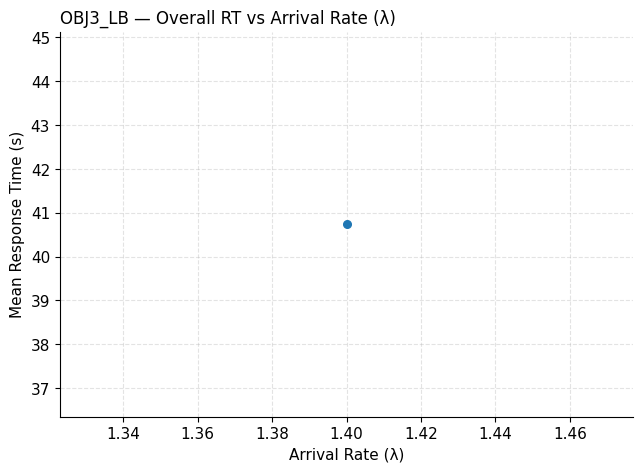

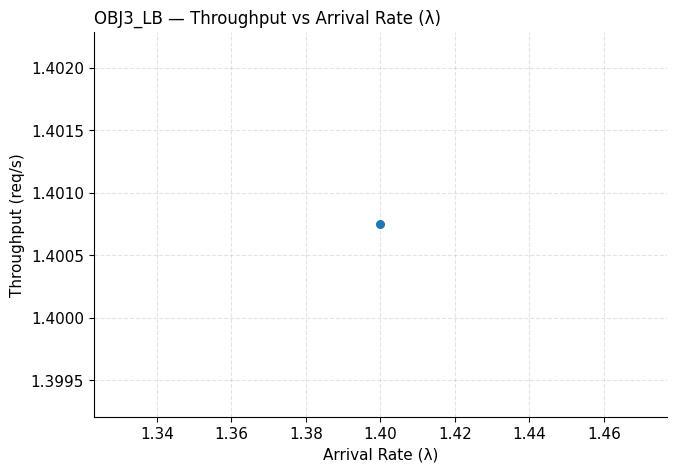

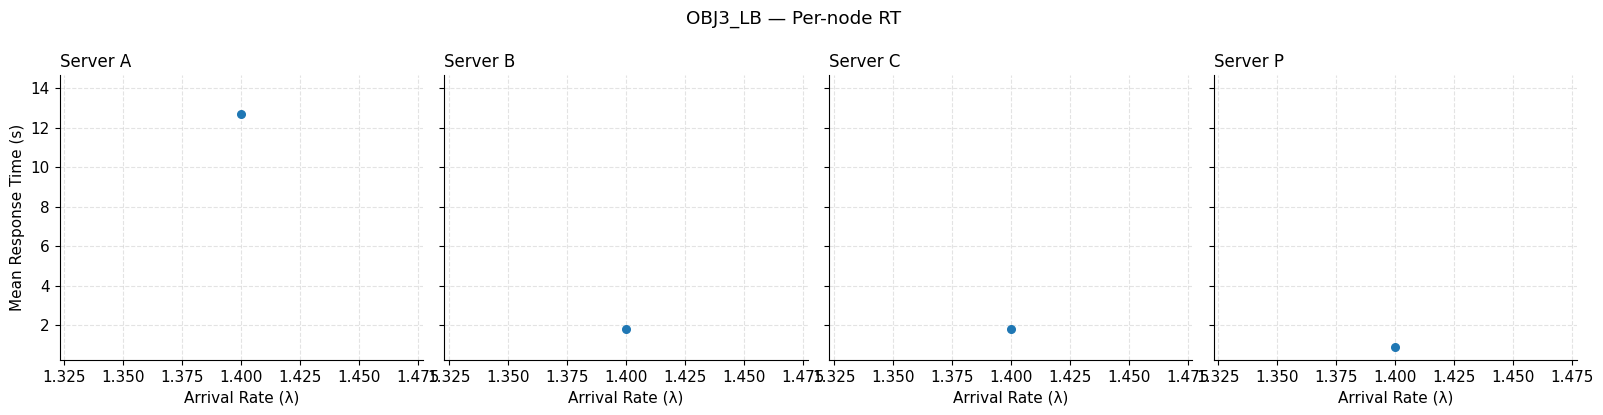

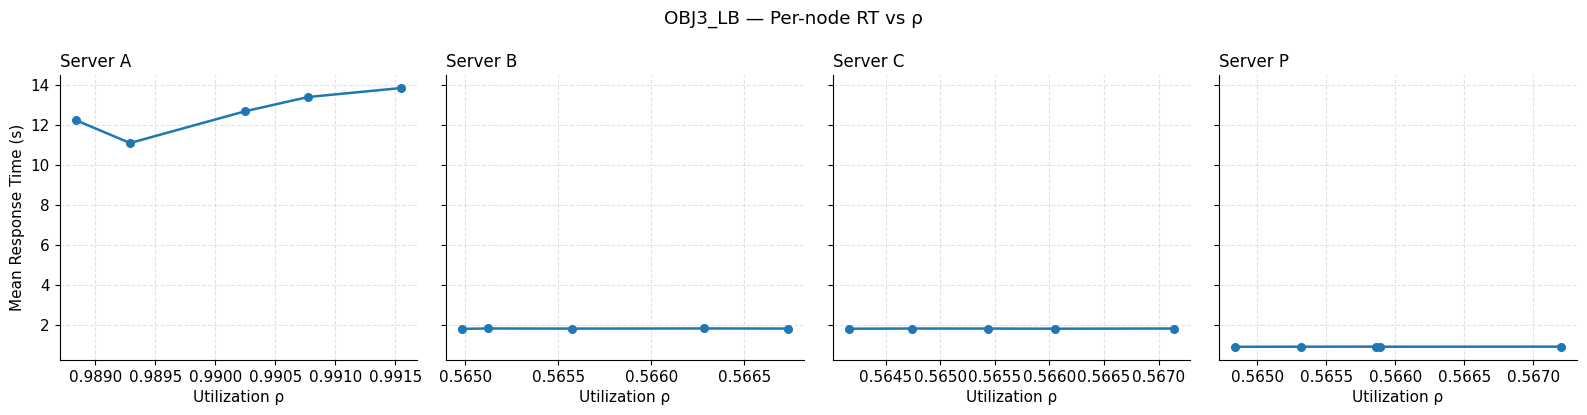


Overall Mean Response Time (mean ± CI95%):


,arrival_rate,n,mean,ci_lo,ci_hi
0,1.400000,5,40.738,36.744,44.732



Overall Throughput (mean ± CI95%):


,arrival_rate,n,mean,ci_lo,ci_hi
0,1.400000,5,1.401,1.399,1.402


In [133]:
# Sanity check
files = find_csv_for_config(config_file, base_dir=BASE_DIR)
print("CSV trovati:", len(files))
for f in files: print(" -", f)

# Grafici + tabella (Torkin-like)
analyze_config(config_file, base_dir=BASE_DIR)
print_summary_table(config_file, base_dir=BASE_DIR)

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------- 1) Stima D_j e X_sat da un DataFrame unico ---------
def estimate_demands_from_df(df: pd.DataFrame) -> dict:
    """Usa OVERALL.throughput = X e, per ogni nodo j, D_j = rho_j / X."""
    df_over = df[df["scope"] == "OVERALL"]
    if df_over.empty or "throughput" not in df_over.columns:
        raise ValueError("Serve la colonna OVERALL.throughput per stimare i demand.")
    X = float(df_over["throughput"].mean())

    out = {}
    df_nodes = df[df["scope"].str.startswith("NODE_")]
    for scope in df_nodes["scope"].unique():
        node = scope.replace("NODE_", "")
        d = df_nodes[df_nodes["scope"] == scope]
        if not d.empty and "utilization" in d.columns:
            rho = float(d["utilization"].mean())
            out[f"D_{node}"] = rho / X

    if not out:
        raise ValueError("Non trovo utilization per i nodi NODE_*.")

    bneck = max(out, key=out.get)
    out["bottleneck"] = bneck
    out["X_sat"] = 1.0 / out[bneck]
    return out

# --------- 2) Curva teorica R(lambda) per M/M/1 in serie ---------
def theoretical_R(lmbda: np.ndarray, D: dict) -> np.ndarray:
    """
    R(λ) = Σ_j D_j / (1 − λ·D_j), valida finché λ·D_j < 1 per tutti i j.
    D deve contenere chiavi tipo D_A, D_B, D_C, D_P...
    """
    R = np.zeros_like(lmbda, dtype=float)
    mask = np.ones_like(lmbda, dtype=bool)
    for key, val in D.items():
        if not key.startswith("D_"):
            continue
        denom = 1.0 - lmbda * val
        R += val / denom
        mask &= (denom > 0)
    R[~mask] = np.nan
    return R

# --------- 3) Aggrega i punti simulati (mean ± CI) vs asse scelto ---------
def aggregate_sim_overall(df_overall: pd.DataFrame):
    """
    Restituisce (df_agg, xcol, xlabel) con colonne:
    [xcol, mean, ci_lo, ci_hi, n].
    """
    xcol, xlabel = choose_overall_x(df_overall)
    rows = []
    for xval, g in df_overall.groupby(xcol):
        m, lo, hi, n = mean_ci(g["mean_response_time"])
        rows.append((xval, m, lo, hi, n))
    out = pd.DataFrame(rows, columns=[xcol, "mean", "ci_lo", "ci_hi", "n"]).sort_values(xcol)
    return out, xcol, xlabel

# --------- 4) Plot overlay teoria + simulazione ---------
def plot_rt_theory_overlay(df_all: pd.DataFrame):
    """
    Disegna overlay tra teoria M/M/1 in serie e simulazione.
    Usa TITLE_PREFIX globale per il titolo.
    """
    # stima D_j e X_sat
    D = estimate_demands_from_df(df_all)
    X_sat = D["X_sat"]

    df_overall = df_all[df_all["scope"] == "OVERALL"].copy()
    if df_overall.empty or "mean_response_time" not in df_overall.columns:
        print("Mancano dati OVERALL/mean_response_time.")
        return

    agg, xcol, xlabel = aggregate_sim_overall(df_overall)

    # griglia per la teoria
    xmin, xmax = float(np.nanmin(agg[xcol])), float(np.nanmax(agg[xcol]))
    grid = np.linspace(max(1e-6, xmin*0.6), xmax*1.1, 400)
    R_theory = theoretical_R(grid, D)

    fig, ax = plt.subplots(figsize=(7.6, 5.0))
    ax.plot(grid, R_theory, label="Teoria (M/M/1 in serie)")

    # banda CI simulazione
    ylo = np.where(np.isfinite(agg["ci_lo"]), agg["ci_lo"], agg["mean"])
    yhi = np.where(np.isfinite(agg["ci_hi"]), agg["ci_hi"], agg["mean"])
    ax.fill_between(agg[xcol], ylo, yhi, alpha=0.18, linewidth=0)
    ax.plot(agg[xcol], agg["mean"], marker="o", linestyle="-", label="Simulazione (mean ± CI95%)")

    # marker X_sat
    ax.axvline(X_sat, linestyle="--", alpha=0.5, label=f"X_sat ≈ {X_sat:.3f}")

    ax.set_xlabel(xlabel)
    ax.set_ylabel("Mean Response Time (s)")
    ax.set_title(f"{TITLE_PREFIX} — Overall RT: teoria vs simulazione")
    ax.grid(True, linestyle="--", alpha=0.35)
    ax.legend()
    plt.show()


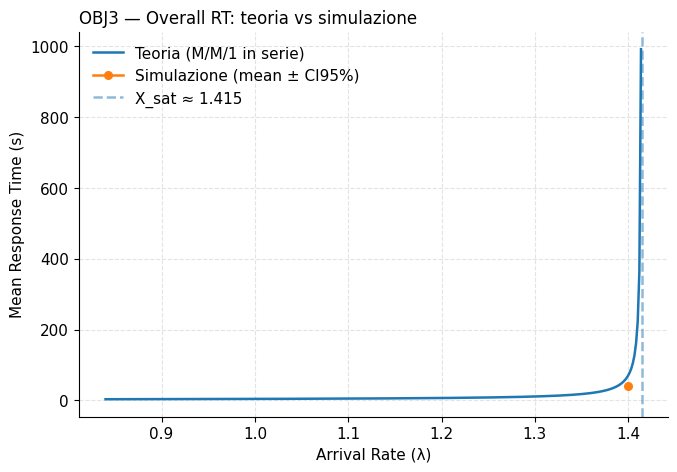

In [140]:



df_all = load_runs(find_csv_for_config(config_file, base_dir=BASE_DIR))
plot_rt_theory_overlay(df_all)



la curva blu esplode asintoticamente quando il throughput si avvicina a 
Xsat≈1.236 che è il limite di stabilità stimato;

i punti arancioni della simulazione (con CI95%) si trovano nella zona stabile a sinistra di 
Xsat e combaciano bene con la teoria;

la linea verticale tratteggiata segna la capacità massima teorica del sistema.

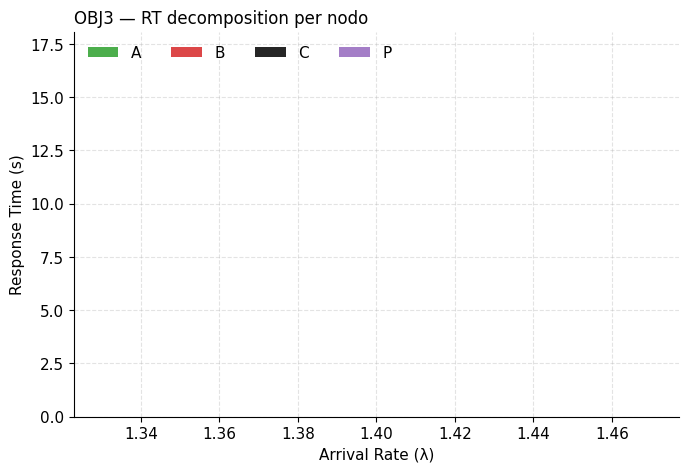

In [142]:
def plot_rt_decomposition(df_all: pd.DataFrame, percent: bool = False):
    """
    Disegna la decomposizione del tempo di risposta per tutti i nodi NODE_* presenti.
    Se percent=True, mostra le percentuali (0–100%) invece dei valori assoluti.
    """
    # filtra righe dei nodi
    dn = df_all[df_all["scope"].astype(str).str.startswith("NODE_")].copy()
    if dn.empty or "mean_response_time" not in dn.columns:
        print("[INFO] Dati insufficienti per RT decomposition.")
        return

    # media per (λ, nodo)
    dn = dn.groupby(["arrival_rate", "scope"], as_index=False).mean(numeric_only=True)

    # pivot: righe = λ, colonne = NODE_*
    piv = dn.pivot(index="arrival_rate", columns="scope", values="mean_response_time").fillna(0.0)

    # ordina colonne alfabeticamente per nodo (A,B,C,P,...)
    cols = sorted(piv.columns, key=lambda s: s.replace("NODE_", ""))
    piv = piv[cols].sort_index()

    # se percentuale, normalizza per riga
    if percent:
        totals = piv.sum(axis=1).replace(0, np.nan)
        piv = piv.div(totals, axis=0) * 100.0

    # etichette "A","B","C","P",... e colori (se PALETTE è definita)
    labels = [c.replace("NODE_", "") for c in piv.columns]
    colors = []
    for lab in labels:
        try:
            colors.append(PALETTE.get(lab, None))  # usa palette se disponibile
        except NameError:
            colors.append(None)  # fallback: colori default di Matplotlib

    # se nessun colore esplicito, lascia che Matplotlib scelga la palette
    use_colors = None if all(c is None for c in colors) else colors

    fig, ax = plt.subplots(figsize=(7.8, 5.0))
    ax.stackplot(piv.index, *[piv[c].values for c in piv.columns],
                 labels=labels, colors=use_colors, alpha=0.85)
    ax.set_xlabel("Arrival Rate (λ)")
    ax.set_ylabel("Share of Response Time (%)" if percent else "Response Time (s)")
    if percent:
        ax.set_ylim(0, 100)
    ax.set_title(f"{TITLE_PREFIX} — RT decomposition per nodo" + (" (%)" if percent else ""))
    ax.legend(loc="upper left", ncol=min(4, len(labels)))
    ax.grid(True, linestyle="--", alpha=0.35)
    plt.show()
plot_rt_decomposition(df_all)

Sull’asse X hai il tasso di arrivo (λ), cioè quante richieste al secondo entrano nel sistema.

Sull’asse Y hai il tempo medio di risposta complessivo, ma scomposto (empilato) per ciascun nodo.

Le aree colorate mostrano quanto ciascun nodo contribuisce al tempo totale.

Interpretazione della figura:

La parte verde (A) è il tempo medio speso sul server A (front-end). Rimane sempre piccola.

La parte viola (P) è il tempo medio sul provider esterno. È quasi costante e poco rilevante.

La parte rossa (B) è il tempo medio speso sul server B (app + DB). Questa cresce rapidamente con λ e diventa dominante.

In altre parole, la figura ti dice visivamente che:

quando il carico è basso, il tempo totale è distribuito un po’ fra tutti i nodi,

ma già per λ intorno a 0.9–1.0 il server B diventa il collo di bottiglia,

e vicino a λ=1.2 quasi tutto il tempo di risposta è dovuto a B.

È un modo elegante per mostrare chi sta rallentando il sistema: la crescita verticale della parte rossa significa che il collo di bottiglia si concentra lì.

Seeds trovati: [123456789, 141421357, 271828183, 314159265, 1732584193]


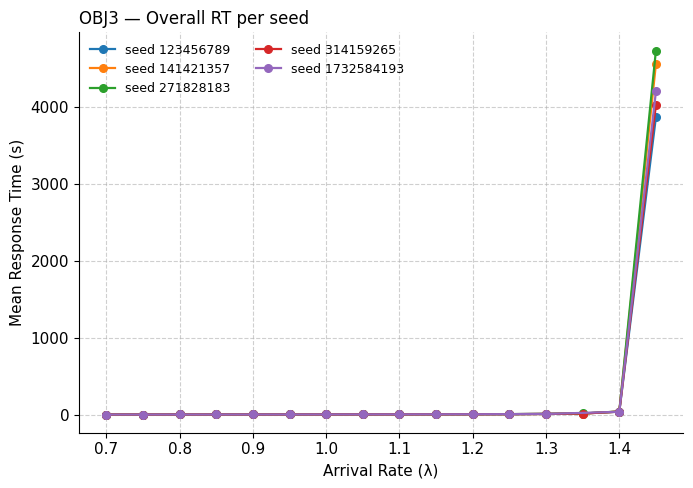

In [145]:
# ========= Curves per SEED dai CSV "arrivals" (versione robusta) =========
# NOTE: riusa mean_ci/line_with_ci già definite

import glob, os, re
from typing import Iterable, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- pattern dinamici in base a OBJ e BASE_DIR ---
def make_patterns(obj: int, base_dir: str) -> list[str]:
    """
    Genera una lista di pattern possibili per i CSV per-seed.
    Tenta varianti con/senza 'arrivals' e diverse separazioni per safety.
    """
    base_dir = base_dir.rstrip("/\\")
    patterns = [
        os.path.join(base_dir, f"results_obj{obj}_arrivals_run*_seed*.csv"),
        os.path.join(base_dir, f"results_obj{obj}_run*_seed*.csv"),
        os.path.join(base_dir, f"results_obj{obj}_arrivals_*seed*.csv"),
        os.path.join(base_dir, f"results_obj{obj}_*seed*.csv"),
    ]
    return patterns

# regex seed più permissivo: _seed42, -seed=42, _seed-42, ecc.
_SEED_RE = re.compile(r"[ _-]seed[=_-]?(\d+)", re.IGNORECASE)

def _coerce_numeric(df: pd.DataFrame, exclude=("scope",)):
    """Converte in numerico tutte le colonne tranne quelle escluse; '-' -> NaN."""
    out = df.replace({"-": np.nan}).copy()
    for c in out.columns:
        if c not in exclude:
            out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

def _seed_from_name(path: str) -> int | None:
    m = _SEED_RE.search(os.path.basename(path))
    return int(m.group(1)) if m else None

def load_arrivals_by_seed(patterns: Iterable[str]) -> pd.DataFrame:
    """
    Carica tutti i CSV che matchano uno QUALSIASI dei pattern,
    aggiunge colonne source/replica/seed. Se non trova nulla, stampa i pattern provati.
    """
    files = []
    for p in patterns:
        files.extend(glob.glob(p))
    files = sorted(set(files))  # dedup
    if not files:
        print("[WARN] Nessun CSV trovato per i pattern seguenti:")
        for p in patterns:
            print(" -", p)
        # opzionale: lista rapida della cartella
        base_dirs = sorted(set(os.path.dirname(p) for p in patterns))
        for d in base_dirs:
            try:
                print(f"\nContenuto di {d}:")
                for name in sorted(os.listdir(d)):
                    if name.endswith(".csv"):
                        print("   ", name)
            except FileNotFoundError:
                print(f"(Cartella inesistente: {d})")
        raise FileNotFoundError("Nessun CSV per-seed trovato.")
    dfs = []
    for i, f in enumerate(files):
        df = pd.read_csv(f)
        df = _coerce_numeric(df)  # numerico ovunque possibile
        df["source"]  = os.path.basename(f)
        df["replica"] = i
        df["seed"]    = _seed_from_name(f)
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

def per_seed_overall(df_all: pd.DataFrame) -> Dict[int, pd.DataFrame]:
    """{seed -> DF OVERALL (una riga per λ, media se più righe)}"""
    df_ov = df_all[df_all["scope"] == "OVERALL"].copy()
    out = {}
    for seed, g in df_ov.groupby("seed"):
        gg = g.groupby("arrival_rate", as_index=False).mean(numeric_only=True)
        gg = gg.sort_values("arrival_rate").reset_index(drop=True)
        out[int(seed) if pd.notna(seed) else -1] = gg
    return out

def per_seed_nodes(df_all: pd.DataFrame) -> Dict[int, pd.DataFrame]:
    """{seed -> DF nodi} una riga per (λ, scope)"""
    dn = df_all.copy()
    dn["scope"] = dn["scope"].astype(str)  # safety contro NaN
    dn = dn[dn["scope"].str.startswith("NODE_")]
    out = {}
    for seed, g in dn.groupby("seed"):
        gg = g.groupby(["arrival_rate", "scope"], as_index=False).mean(numeric_only=True)
        gg = gg.sort_values(["arrival_rate", "scope"]).reset_index(drop=True)
        out[int(seed) if pd.notna(seed) else -1] = gg
    return out

# ----------------------------- plotting --------------------------------

def plot_overall_rt_per_seed(seed_to_df: Dict[int, pd.DataFrame],
                             title=None, ylabel="Mean Response Time (s)"):
    """Curve OVERALL per ogni seed (senza CI, uno per seed)."""
    plt.figure(figsize=(7.8,5.2))
    for seed, df in sorted(seed_to_df.items()):
        if {"arrival_rate", "mean_response_time"}.issubset(df.columns):
            plt.plot(df["arrival_rate"], df["mean_response_time"],
                     marker="o", linewidth=1.6, label=f"seed {seed}")
    plt.xlabel("Arrival Rate (λ)")
    plt.ylabel(ylabel)
    plt.title(title or f"{TITLE_PREFIX} — Overall RT per seed")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(ncol=2, fontsize=9)
    plt.show()

def plot_node_rt_per_seed(seed_to_nodes: Dict[int, pd.DataFrame], title=None):
    """Curve per nodo (A/B/P) per ciascun seed (senza CI)."""
    markers = {"NODE_A":"o", "NODE_B":"s", "NODE_P":"^"}
    plt.figure(figsize=(8.2,5.2))
    for seed, df in sorted(seed_to_nodes.items()):
        for node, g in df.groupby("scope"):
            if {"arrival_rate","mean_response_time"}.issubset(g.columns):
                lab = f"{node.replace('NODE_','S. ')} — seed {seed}"
                plt.plot(g["arrival_rate"], g["mean_response_time"],
                         marker=markers.get(node, "o"), linewidth=1.4, label=lab)
    plt.xlabel("Arrival Rate (λ)")
    plt.ylabel("Mean Response Time (s)")
    plt.title(title or f"{TITLE_PREFIX} — Per-node RT per seed")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(ncol=2, fontsize=8)
    plt.show()

def plot_overall_rt_mean_ci_across_seeds(seed_to_df: Dict[int, pd.DataFrame], title=None):
    """Media cross-seed con CI95% riusando line_with_ci."""
    frames = []
    for seed, df in seed_to_df.items():
        if {"arrival_rate", "mean_response_time"}.issubset(df.columns):
            frames.append(df[["arrival_rate", "mean_response_time"]])
    if not frames:
        print("[INFO] Nessun dato OVERALL per costruire la media cross-seed.")
        return
    big = pd.concat(frames, ignore_index=True)
    line_with_ci(
        big, x="arrival_rate", y="mean_response_time",
        title=title or f"{TITLE_PREFIX} — Overall RT (mean ± CI95%) across seeds",
        xlabel="Arrival Rate (λ)", ylabel="Mean Response Time (s)"
    )

# --------- ESEMPIO DI USO ---------
patterns = make_patterns(OBJ, BASE_DIR)
df_all = load_arrivals_by_seed(patterns)
print("Seeds trovati:", sorted(df_all["seed"].dropna().unique().astype(int).tolist()))

by_seed_overall = per_seed_overall(df_all)
plot_overall_rt_per_seed(by_seed_overall)

by_seed_nodes = per_seed_nodes(df_all)
# plot_node_rt_per_seed(by_seed_nodes)  # scommenta se vuoi anche per nodo

